# Part 1: Parameter Encoding

In this notebook, we will review how relaxation parameters (i.e. $T_1$ and $T_2$) and sequence parameters (i.e. $TE$, $TR$ and $TI$) determine MR image contrast. We will use a publicy available [Python-based Bloch simulator](https://sycomore.readthedocs.io/en/latest/). First, we define several helper functions for the forthcoming exercises:

In [31]:
# Setup
import numpy as np
import matplotlib.pyplot as plt

import sycomore
from sycomore.units import *

# Gradient Echo sequence
def gresimulation(T1, T2, T2_star, TR):

    # calculate T2'
    R2 = 1/T2 
    R2_star = 1/T2_star 
    R2p = R2_star - R2
    df = R2p*(np.tan(np.pi*(np.random.rand(250)-0.5))) #frequency distribution inside voxel

    # Initialize simulation
    sampling_time = 10
    nSamples = int(TR/sampling_time)
    mVoxel = np.zeros((nSamples, df.size), dtype=np.complex128) 

    ExcitationPulse = sycomore.bloch.pulse(90*deg,0*deg)

    # Start sequence
    for freq in range(df.size):
        # Set up tissues
        tissue = sycomore.Species( T1*ms, T2*ms, delta_omega=df[freq]/2/np.pi*kHz )
        
        # Set up evolution matrix
        EvolutionMatrix = sycomore.bloch.time_interval(tissue, sampling_time*ms)

        # Set up isochromat and apply RF pulse
        mIsochromat = np.array([0., 0., 1., 1.])   
        mIsochromat = np.matmul(ExcitationPulse, mIsochromat) 

        # Do simulation
        for time in range(nSamples):
            mIsochromat = np.matmul(EvolutionMatrix,mIsochromat)
            mVoxel[time, freq] = mIsochromat[0] + 1j*mIsochromat[1]
       
    # build output
    time = np.arange(sampling_time,TR+sampling_time,sampling_time) 
    sig = np.zeros(time.size, dtype=[("time", sycomore.Quantity), ("signal", complex)])
    sig = (time, np.mean(mVoxel,1))
          
    return sig

# Spin Echo sequence
def sesimulation(T1, T2, T2_star, tau, TR):

    # calculate T2'
    R2 = 1/T2 
    R2_star = 1/T2_star 
    R2p = R2_star - R2
    df = R2p*(np.tan(np.pi*(np.random.rand(250)-0.5))) #frequency distribution inside voxel

    # Initialize simulation
    sampling_time = 10
    nSamplesTau = int(tau/sampling_time)
    nSamplesTauTR = int((TR-tau)/sampling_time)
    nSamples = int(TR/sampling_time)
    mVoxel = np.zeros((nSamples, df.size), dtype=np.complex128) 

    ExcitationPulse = sycomore.bloch.pulse(90*deg,0*deg)
    RefocusingPulse = sycomore.bloch.pulse(180*deg,0*deg)

    # Start sequence
    for freq in range(df.size):
        # Set up tissues
        tissue = sycomore.Species( T1*ms, T2*ms, delta_omega=df[freq]/2/np.pi*kHz )
        
        # Set up evolution matrix
        EvolutionMatrix = sycomore.bloch.time_interval(tissue, sampling_time*ms)

        # Set up isochromat and apply RF pulse
        mIsochromat = np.array([0., 0., 1., 1.])   
        mIsochromat = np.matmul(ExcitationPulse, mIsochromat) 

        # Do simulation
        for time in range(nSamplesTau):
            mIsochromat = np.matmul(EvolutionMatrix,mIsochromat)
            mVoxel[time, freq] = mIsochromat[0] + 1j*mIsochromat[1]

        # Apply Refocusing pulse
        mIsochromat = np.matmul(RefocusingPulse, mIsochromat) 

        # Do simulation
        for time in range(nSamplesTauTR):
            mIsochromat = np.matmul(EvolutionMatrix,mIsochromat)
            mVoxel[time + nSamplesTau, freq] = mIsochromat[0] + 1j*mIsochromat[1]
       
    # build output
    time = np.arange(sampling_time,TR+sampling_time,sampling_time) 
    sig = np.zeros(time.size, dtype=[("time", sycomore.Quantity), ("signal", complex)])
    sig = (time, np.mean(mVoxel,1))
          
    return sig

# Hahn Echo sequence
def hahnsimulation(T1, T2, T2_star, tau, TR):

    # calculate T2'
    R2 = 1/T2 
    R2_star = 1/T2_star 
    R2p = R2_star - R2
    df = R2p*(np.tan(np.pi*(np.random.rand(250)-0.5))) #frequency distribution inside voxel

    # Initialize simulation
    sampling_time = 10
    nSamplesTau = int(tau/sampling_time)
    nSamplesTauTR = int((TR-tau)/sampling_time)
    nSamples = int(TR/sampling_time)
    mVoxel = np.zeros((nSamples, df.size), dtype=np.complex128) 

    ExcitationPulse = sycomore.bloch.pulse(90*deg,0*deg)
    RefocusingPulse = sycomore.bloch.pulse(90*deg,0*deg) # Hahn Spin Echo!

    # Start sequence
    for freq in range(df.size):
        # Set up tissues
        tissue = sycomore.Species( T1*ms, T2*ms, delta_omega=df[freq]/2/np.pi*kHz )
        
        # Set up evolution matrix
        EvolutionMatrix = sycomore.bloch.time_interval(tissue, sampling_time*ms)

        # Set up isochromat and apply RF pulse
        mIsochromat = np.array([0., 0., 1., 1.])   
        mIsochromat = np.matmul(ExcitationPulse, mIsochromat) 

        # Do simulation
        for time in range(nSamplesTau):
            mIsochromat = np.matmul(EvolutionMatrix,mIsochromat)
            mVoxel[time, freq] = mIsochromat[0] + 1j*mIsochromat[1]

        # Apply Refocusing pulse
        mIsochromat = np.matmul(RefocusingPulse, mIsochromat) 

        # Do simulation
        for time in range(nSamplesTauTR):
            mIsochromat = np.matmul(EvolutionMatrix,mIsochromat)
            mVoxel[time + nSamplesTau, freq] = mIsochromat[0] + 1j*mIsochromat[1]
       
    # build output
    time = np.arange(sampling_time,TR+sampling_time,sampling_time) 
    sig = np.zeros(time.size, dtype=[("time", sycomore.Quantity), ("signal", complex)])
    sig = (time, np.mean(mVoxel,1))
          
    return sig

# Spin Echo steady state signal calculated with extended phase graphs
def sesignal(T1,T2,TE,TR):
    tissue = sycomore.Species(T1*ms, T2*ms)
    sig = np.zeros(10,dtype=np.complex128)
    model = sycomore.epg.Regular(tissue)

    # repeat to reach steady state
    for echo in range(10): 
        model.apply_pulse(90*deg)
        model.apply_time_interval(TE*ms/2)
        model.apply_pulse(180*deg)
        model.apply_time_interval(TE*ms/2)
        sig = model.echo
        model.apply_time_interval((TR-TE)*ms)
    
    return sig

def sesignalTE(T1,T2,TR):
    TE = np.arange(1,500,10)
    sig = np.zeros(TE.size,dtype=np.complex128)
    for te in range(TE.size):
        sig[te] = sesignal(T1,T2,TE[te],TR)

    return sig

def sesignalTR(T1,T2,TE):
    TR = np.arange(10,5000,100)
    sig = np.zeros(TR.size,dtype=np.complex128)
    for tr in range(TR.size):
        sig[tr] = sesignal(T1,T2,TE,TR[tr])

    return sig

# IR-prepared Spin Echo steady state signal calculated with extended phase graphs
def irsesignal(T1,T2,TI,TE,TR):
    tissue = sycomore.Species(T1*ms, T2*ms)
    sig = np.zeros(10,dtype=np.complex128)
    model = sycomore.epg.Regular(tissue)

    # repeat to reach steady state
    for echo in range(10): 
        model.apply_pulse(180*deg)
        model.apply_time_interval(TI*ms)
        model.apply_pulse(90*deg)
        model.apply_time_interval(TE*ms/2)
        model.apply_pulse(180*deg)
        model.apply_time_interval(TE*ms/2)
        sig = model.echo
        model.apply_time_interval((TR-TE)*ms)
    
    return sig

def irsesignalTI(T1,T2,TE,TR):
    TI = np.arange(10,5000,100)
    sig = np.zeros(TI.size,dtype=np.complex128)
    for ti in range(TI.size):
        sig[ti] = irsesignal(T1,T2,TI[ti],TE,TR)

    return sig

# Ex. 01: Echo Formation

Here, we will study the properties of the Spin-Echo sequence, one of the basic MRI sequences. First, we will review how $T_2$ can be achieved by applying a refocusing pulse after the excitation pulse.

## Pt. 1: $T_2^*$ Effect

After a $90°$ excitation pulse, transverse magnetization starts to dephase leading to signal loss. From the solution of the Bloch equation, it can be shown that this relaxation follows an exponential behaviour:

$$
M_x(t) = M_{x0} e^{-t/T_2}
$$
$$
M_y(t) = M_{y0} e^{-t/T_2}
$$

where $M_{x0,y0}$ are the $x,y$ component of the magnetization after the excitation, determined by the phase of the rf pulse.
However, intravoxel field inhomogeneities lead to additional dephasing and a faster signal loss:
$$
M_x(t) = M_{x0} e^{-t/T_2^*}
$$
$$
M_y(t) = M_{y0} e^{-t/T_2^*}
$$

where $1/T_2^* = 1/T_2 + 1/T_2^{'}$ and $T_2^{'}$ represents the contribution of these intravoxel inhomogeneities to transverse decay.

To show this effect, we will now simulate a Gradient Echo readout. Function call for the simulation is:

` out = gresimulation(T1,T2,T2*,TR)`

Repeat the simulation for two signal with the same $T_1, T_2$ (e.g. $T_1 = 1000$ms; $T_2 = 500$ms) and different $T_2^*$. Set the $TR=5000$ms and plot the solution (code for plot provided). What do you see?

In [17]:
# calculate signal evolutions
sigA = gresimulation(1000,500,50,5000)
sigB = gresimulation(1000,500,100,5000)

Text(0.5, 1.0, 'Gradient Echo readout')

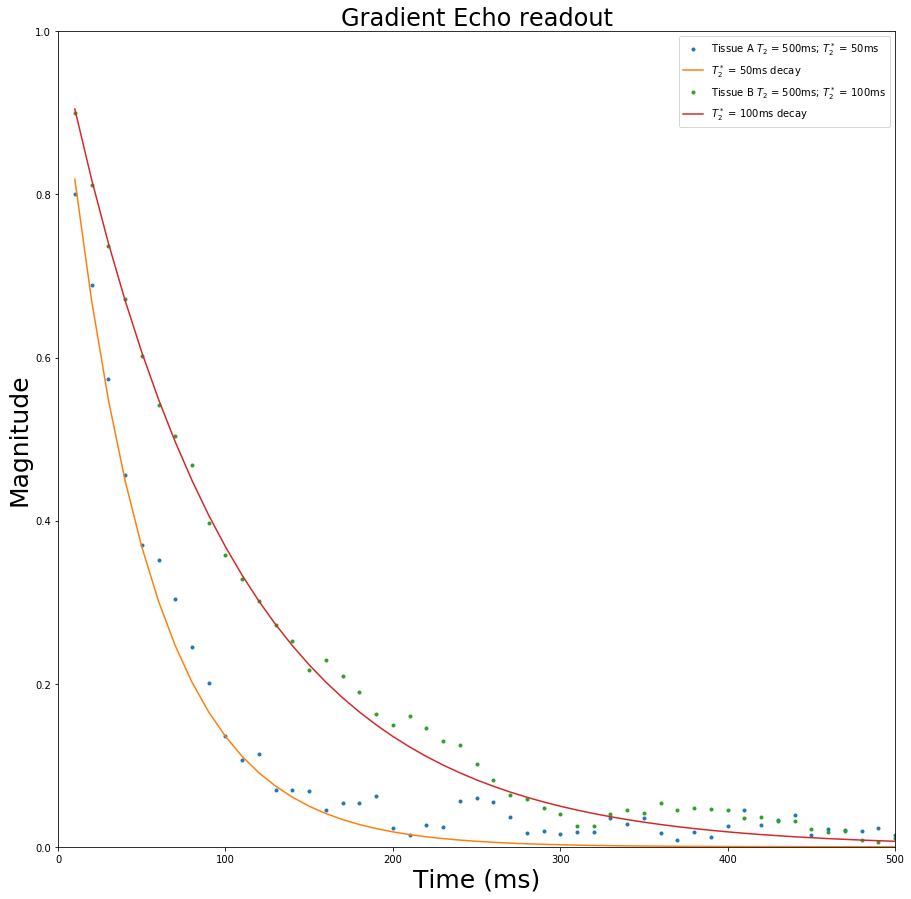

In [18]:
# Plot
times = sigA[0]
magnitudeA = np.abs(sigA[1])
magnitudeB = np.abs(sigB[1])

plt.plot(times, magnitudeA, ".", label="Tissue A $T_2$ = 500ms; $T_2^*$ = 50ms")
plt.plot(times, np.exp(-times/50),label="$T_2^*$ = 50ms decay")
plt.plot(times, magnitudeB, ".", label="Tissue B $T_2$ = 500ms; $T_2^*$ = 100ms")
plt.plot(times, np.exp(-times/100),label="$T_2^*$ = 100ms decay")
plt.rcParams['figure.figsize'] = [15, 15]
plt.ylim(0,1)
plt.xlim(0,500)
plt.xlabel("Time (ms)",fontsize=25)
plt.ylabel("Magnitude",fontsize=25)
plt.legend()
times = sigB[0]
magnitude = np.abs(sigB[1])
plt.title("Gradient Echo readout",fontsize=24)

## Pt. 2:  Signal recovery

It can be shown that, if a $180°$ pulse (refocusing pulse) is applied after a time $\tau$ after the excitation pulse, the dephasing due to intravoxel inhomogeneities is reverted and, after an additional time $\tau$, the $T_2^{'}$ part of the transverse the decay can be recovered. This phenomenon is called "Echo" and the time $TE=2\tau$ is called "Echo Time". This sequence is known as "Spin-Echo" . We will now simulate a Spin-Echo readout to show the refocusing phenomenon. Function call for the simulation is:

` out = sesimulation(T1,T2,T2*,tau,TR)`

Perform the simulation with the same parameters of Pt. 1 and plot the results. What do you see now? 

In [19]:
# calculate signal evolutions
sigA = sesimulation(1000,500,50,100,5000)
sigB = sesimulation(1000,500,100,100,5000)

Text(0.5, 1.0, 'Spin Echo readout')

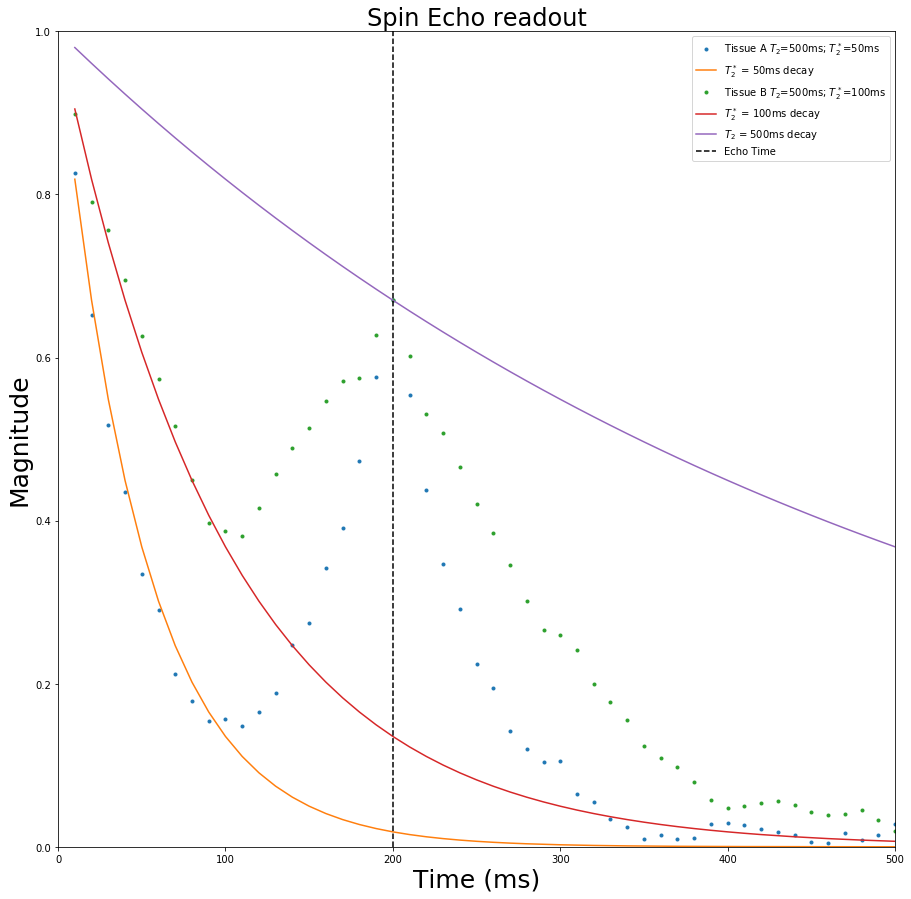

In [20]:
# Plot
times = sigA[0]
magnitudeA = np.abs(sigA[1])
magnitudeB = np.abs(sigB[1])

plt.plot(times, magnitudeA, ".", label="Tissue A $T_2$=500ms; $T_2^*$=50ms")
plt.plot(times, np.exp(-times/50),label="$T_2^*$ = 50ms decay")
plt.plot(times, magnitudeB, ".", label="Tissue B $T_2$=500ms; $T_2^*$=100ms")
plt.plot(times, np.exp(-times/100),label="$T_2^*$ = 100ms decay")
plt.plot(times, np.exp(-times/500),label="$T_2$ = 500ms decay")
plt.plot((200,200),(0,1),'--k',label="Echo Time")
plt.rcParams['figure.figsize'] = [15, 15]
plt.ylim(0,1)
plt.xlim(0,500)
plt.xlabel("Time (ms)",fontsize=25)
plt.ylabel("Magnitude",fontsize=25)
plt.legend()
times = sigB[0]
magnitude = np.abs(sigB[1])
plt.title("Spin Echo readout",fontsize=24)

## Pt. 3: Non-180° Echo Pulses

In the [original paper from Hahn](http://mri-q.com/uploads/3/4/5/7/34572113/hahn_spin_echo_paper_1950.pdf), a $90°$ refocusing pulse was used instead of the common $180°$. In fact, it can be show that each rf-pulse can be decomposed in a $0°$ component, a $90°$ component (which converts longitudinal magnetization into transverse magnetization and vice-versa) and a $180°$ component (which exchange the dephasing and the rephasing components of the transverse magnetization). The weights of these components is determined by the flip angle. The proof can be found in [Haacke et al., Magnetic Resonance Imaging: physical principles and sequence design, Chapter 18.3.1, pp. 481-484](https://onlinelibrary.wiley.com/doi/pdf/10.1002/9781118633953.ch18). In other words, any rf-pulse produce a recovery of the $T_2^{'}$ decay.

We will now simulate a $90°$ Spin Echo experiment and we will compare the signal behaviour with the $180°$ Spin Echo sequence. Function call for the $90°$ Spin Echo simulation is:

` out = hahnsimulation(T1,T2,T2*,tau,TR)`

Simulate the signal behaviour of the same tissue and the same sequence timing (e.g. $T_1=1000$ms; $T_2=500$ms, $T_2^*=50$ms, $\tau=100$ms and $TR=5000$ms) and plot the result. What do you see? When do the echoes occour for the two sequences? Are the echo intensities the same?

In [21]:
# calculate signal evolutions
sigA = sesimulation(1000,500,50,100,5000)
sigB = hahnsimulation(1000,500,50,100,5000)

Text(0.5, 1.0, 'Hahn Echo readout')

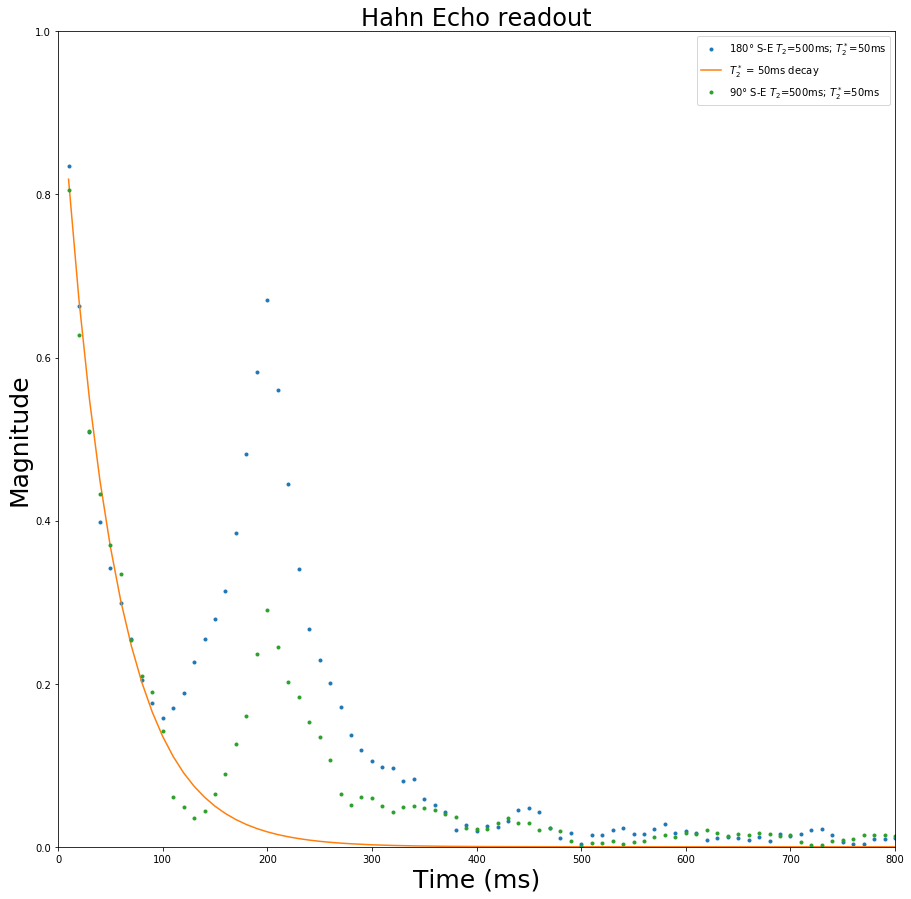

In [23]:
# Plot
times = sigA[0]
magnitudeA = np.abs(sigA[1])
magnitudeB = np.abs(sigB[1])

plt.plot(times, magnitudeA, ".", label="180° S-E $T_2$=500ms; $T_2^*$=50ms")
plt.plot(times, np.exp(-times/50),label="$T_2^*$ = 50ms decay")
plt.plot(times, magnitudeB, ".", label="90° S-E $T_2$=500ms; $T_2^*$=50ms")
plt.rcParams['figure.figsize'] = [15, 15]
plt.ylim(0,1)
plt.xlim(0,800)
plt.xlabel("Time (ms)",fontsize=25)
plt.ylabel("Magnitude",fontsize=25)
plt.legend()
times = sigB[0]
magnitude = np.abs(sigB[1])
plt.title("Hahn Echo readout",fontsize=24)

# Ex. 02: Image Contrast

We will now study how to control the Spin-Echo signal weighting by setting sequence $TE$ and $TR$. Rather than plotting the signal intensity over the whole experiment, we will focus on the signal intensity at $TE$, which represent the image signal intensity. In fact, the center of k-space, which represent the image contrast, is sampled at TE (review the Week 01 exercises to see why the center of k-space contains information about image contrast). The following exercises are inspired by Prof. Brian Hargreaves (Stanford University): [his webpage](http://mrsrl.stanford.edu/~brian/bloch/) contains additional useful exercises to better understand MR signal behaviour.

## Pt. 1: Echo Time dependency
As we saw in Part 1., transverse magnetization at Echo Time is modulated by $T_2$ decay. Therefore, we can change the amount of $T_2$ weighting by changing the $TE$.

Simulate the signal intensity at fixed $TR$ and different $TE$s for two different tissues with the same $T1$ but different $T_2$ (e.g. $T_1=1000$ms and $T_2=100/50$ms). Try with a long $TR$ (e.g. $TR=10000$ms). Function call is:

` out = sesignalTE(T1,T2,TR)`

Plot both tissue A and tissue B signal intensity as well as their difference (i.e. the *contrast*). How does the contrast change as a function of the $TE$? For which $TE$s we reach the higher $T_2$ contrast?

In [24]:
# calculate signal evolutions
sigA = sesignalTE(1000,100,10000)
sigB = sesignalTE(1000,50,10000)

Text(0.5, 1.0, 'Contrast vs TE (TR=10s)')

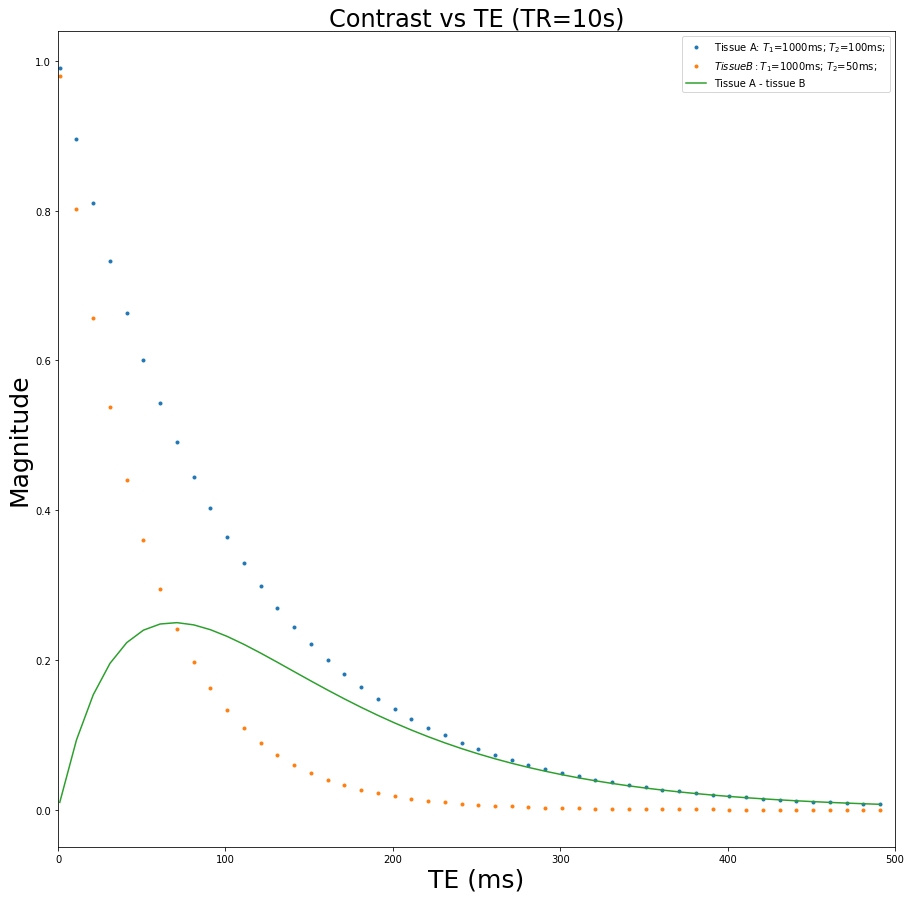

In [25]:
# Plot
times = np.arange(1,500,10)
magnitudeA = np.abs(sigA)
magnitudeB = np.abs(sigB)

plt.plot(times, magnitudeA, ".", label="Tissue A: $T_1$=1000ms; $T_2$=100ms;")
plt.plot(times, magnitudeB, ".", label="$Tissue B: T_1$=1000ms; $T_2$=50ms;")
plt.plot(times, magnitudeA - magnitudeB,label="Tissue A - tissue B")
plt.rcParams['figure.figsize'] = [15, 15]
plt.xlim(0,500)
plt.xlabel("TE (ms)",fontsize=25)
plt.ylabel("Magnitude",fontsize=25)
plt.legend()
plt.title("Contrast vs TE (TR=10s)",fontsize=24)

## Pt. 2: Repetition Time dependency
As presented in Ex. 01., transverse decay (and therefore the MR signal intensity) is independent from the longitudinal relaxation time $T_1$. This is true if the magnetization is in its equilibrium state $M_0$ before the excitation pulse, i.e. if we use a repetition time long enough to allow complete longitudinal relaxation for each spin. If we use a short $TR$ (i.e. $TR>>T_1$ does not hold), longitudinal magnetization available for the excitation will be modulated by $T_1$:

$$
M_z(t_{rf}^-) \propto (1-e^{-TR/T_1})
$$

Therefore, the transverse magnetization at $TE$ (and the signal intensity), will be modulated by both $T_2$ (the amount of $T_2$ weighting given by $TE$) and $T_1$ (the amount of $T_1$ weighting given by $TR$).

Now repeat Ex. 04 with fixed $TR$ and different $TE$s. Simulate two tissues with same $T_2$ and different $T_1$ (e.g. $T_1=1500/250$ms and $T_2=100$ms). Function call is:

` out = sesignalTR(T1,T2,TE)`

Use a short $TE$ (e.g. 1ms). Again, plot both tissue A and tissue B signal intensity as well as their difference. How does the contrast change as a function of the $TR$? For which $TR$s we reach the higher $T_1$ contrast?

In [26]:
# calculate signal evolutions
sigA = sesignalTR(1500,100,1)
sigB = sesignalTR(250,100,1)

In [27]:
# Plot
times = np.arange(10,5000,100)
magnitudeA = np.abs(sigA)
magnitudeB = np.abs(sigB)

plt.plot(times, magnitudeA, ".", label="Tissue A: $T_1$=1500ms; $T_2$=100ms;")
plt.plot(times, magnitudeB, ".", label="$Tissue B: T_1$=250ms; $T_2$=100ms;")
plt.plot(times, magnitudeA - magnitudeB,label="Tissue A - tissue B")
plt.rcParams['figure.figsize'] = [15, 15]
plt.xlim(0,5000)
plt.xlabel("TR (ms)",fontsize=25)
plt.ylabel("Magnitude",fontsize=25)
plt.legend()
plt.title("Contrast vs TR (TE=1ms)",fontsize=24)

Text(0.5, 1.0, 'Contrast vs TR (TE=1ms)')

## Pt. 3: Inversion Time dependency
In Pt.2, we saw that we can encode $T_1$ weighting in the MR signal by using a short $TR$. An alternative approach is to apply a $180°$ preparation pulse before the Spin-Echo readout. The preparation pulse will revert the sign of the longitudinal magnetization (therefore it is called *Inversion Pulse*). Hence, longitudinal magnetization available for the excitation will be modulated by the $T_1$ relaxation time and the time between the inversion pulse and the excitation pulse (i.e. *Inversion Time*) according to:

$$
M_z(t_{rf}^-) \propto (1-2e^{-TI/T_1})
$$

Therefore, the transverse magnetization at $TE$ (and the signal intensity), will be modulated by both $T_2$ (the amount of $T_2$ weighting given by $TE$) and $T_1$ (the amount of $T_1$ weighting given by the inversion time $TI$).

Now repeat Ex. 04 with fixed $TR/TE$ and different $TI$s. Simulate two tissues with same $T_2$ and different $T_1$ (e.g. $T_1=1500/250$ms and $T_2=100$ms). Function call is:

` out = irsesignalTI(T1,T2,TE,TR)`

Use a short $TE$ (e.g. 1ms) and long $TR$ (e.g. 10000ms). Again, plot both tissue A and tissue B signal intensity as well as their difference. How does the contrast change as a function of the $TI$? For which $TI$s we reach the higher $T_1$ contrast?

In [32]:
# calculate signal evolutions
sigA = irsesignalTI(1500,100,1,10000)
sigB = irsesignalTI(250,100,1,10000)

Text(0.5, 1.0, 'Contrast vs TI (TE=1ms,TR=10000ms)')

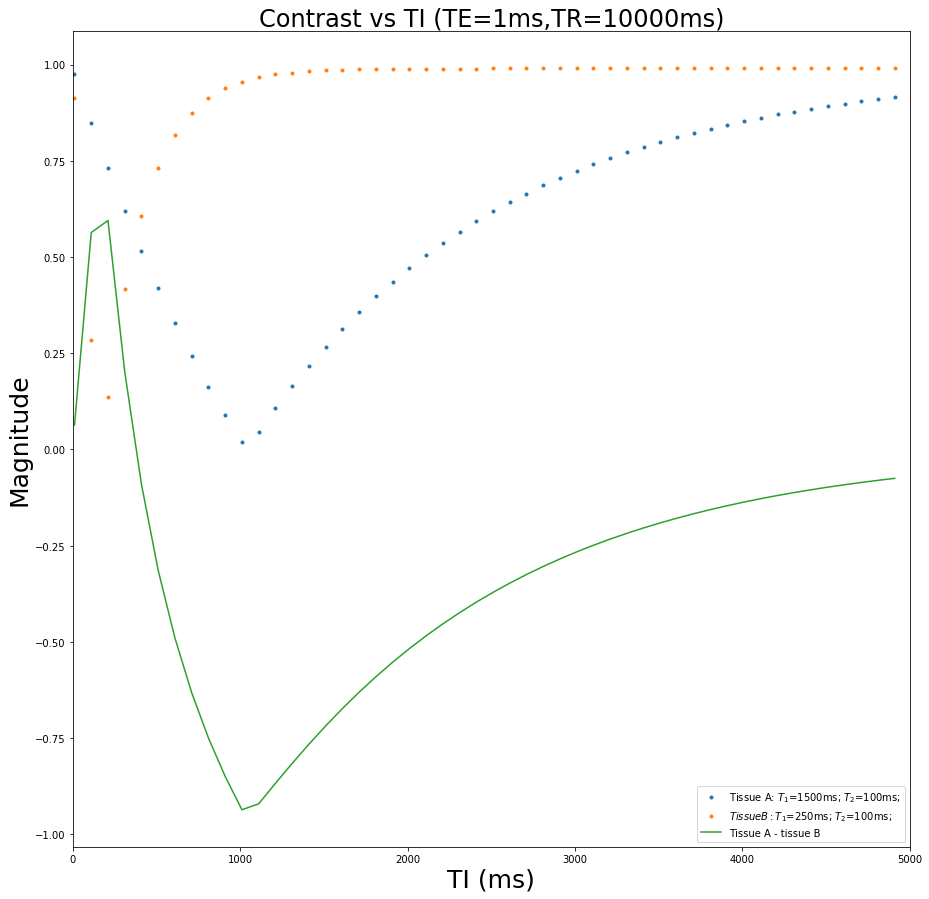

In [33]:
# Plot
times = np.arange(10,5000,100)
magnitudeA = np.abs(sigA)
magnitudeB = np.abs(sigB)

plt.plot(times, magnitudeA, ".", label="Tissue A: $T_1$=1500ms; $T_2$=100ms;")
plt.plot(times, magnitudeB, ".", label="$Tissue B: T_1$=250ms; $T_2$=100ms;")
plt.plot(times, magnitudeA - magnitudeB,label="Tissue A - tissue B")
plt.rcParams['figure.figsize'] = [15, 15]
plt.xlim(0,5000)
plt.xlabel("TI (ms)",fontsize=25)
plt.ylabel("Magnitude",fontsize=25)
plt.legend()
plt.title("Contrast vs TI (TE=1ms,TR=10000ms)",fontsize=24)

# Quantitative Imaging

Given the previous exercises, how would you design an experiment to measure the $T_1$ of a tissue? What about $T_2$?